<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#UK-Data" data-toc-modified-id="UK-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>UK Data</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Fit-and-Predict" data-toc-modified-id="Fit-and-Predict-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit and Predict</a></span></li><li><span><a href="#Display-Actual-vs-Prediction" data-toc-modified-id="Display-Actual-vs-Prediction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Display Actual vs Prediction</a></span></li><li><span><a href="#Are-there-day-patterns?" data-toc-modified-id="Are-there-day-patterns?-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Are there day patterns?</a></span></li><li><span><a href="#Commentary" data-toc-modified-id="Commentary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Commentary</a></span><ul class="toc-item"><li><span><a href="#21st-May" data-toc-modified-id="21st-May-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>21st May</a></span></li><li><span><a href="#7th-May" data-toc-modified-id="7th-May-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>7th May</a></span></li><li><span><a href="#2nd-May" data-toc-modified-id="2nd-May-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>2nd May</a></span></li><li><span><a href="#1st-May" data-toc-modified-id="1st-May-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>1st May</a></span></li><li><span><a href="#28th-April" data-toc-modified-id="28th-April-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>28th April</a></span></li><li><span><a href="#14th-April" data-toc-modified-id="14th-April-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>14th April</a></span></li><li><span><a href="#12th-April" data-toc-modified-id="12th-April-6.7"><span class="toc-item-num">6.7&nbsp;&nbsp;</span>12th April</a></span></li><li><span><a href="#11th-April" data-toc-modified-id="11th-April-6.8"><span class="toc-item-num">6.8&nbsp;&nbsp;</span>11th April</a></span></li><li><span><a href="#10th-April" data-toc-modified-id="10th-April-6.9"><span class="toc-item-num">6.9&nbsp;&nbsp;</span>10th April</a></span></li><li><span><a href="#8th-April" data-toc-modified-id="8th-April-6.10"><span class="toc-item-num">6.10&nbsp;&nbsp;</span>8th April</a></span></li><li><span><a href="#7th-April" data-toc-modified-id="7th-April-6.11"><span class="toc-item-num">6.11&nbsp;&nbsp;</span>7th April</a></span></li><li><span><a href="#3rd-April" data-toc-modified-id="3rd-April-6.12"><span class="toc-item-num">6.12&nbsp;&nbsp;</span>3rd April</a></span></li><li><span><a href="#31st-March" data-toc-modified-id="31st-March-6.13"><span class="toc-item-num">6.13&nbsp;&nbsp;</span>31st March</a></span></li></ul></li><li><span><a href="#Previous-Model-Values" data-toc-modified-id="Previous-Model-Values-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Previous Model Values</a></span></li></ul></div>

## UK Data
Official figures are here:
* https://www.gov.uk/guidance/coronavirus-covid-19-information-for-the-public#number-of-cases-and-deaths

## Load data

In [1]:
import sys
from os import path
sys.path.append(path.pardir)
from src.covid import CovidCountry
import pandas as pd
import numpy as np

# Load and fix UK data
country = 'United Kingdom'
filepath = '../data/raw/'
fix_data = {'2020-03-12': 590,
            '2020-03-15': 1391,
            '2020-03-19': 3269,}

uk = CovidCountry(country=country,
                  filepath=filepath,
                  fixes=fix_data)

uk.load()

## Fit and Predict

In [2]:
uk.fit(curve='gamma')
gb_df = uk.predict()
uk.save(filepath='../data/processed/')

In [3]:
# Show small window of prediction and actual
gb_df[pd.Timestamp.now().date()-pd.Timedelta('3D'):].diff()[1:6]

,Actual,Prediction
Date,,
2020-06-05,1650.0,1378.387378
2020-06-06,1557.0,1311.207035
2020-06-07,NaN,1246.587629
2020-06-08,NaN,1184.491048
2020-06-09,NaN,1124.874225


## Display Actual vs Prediction

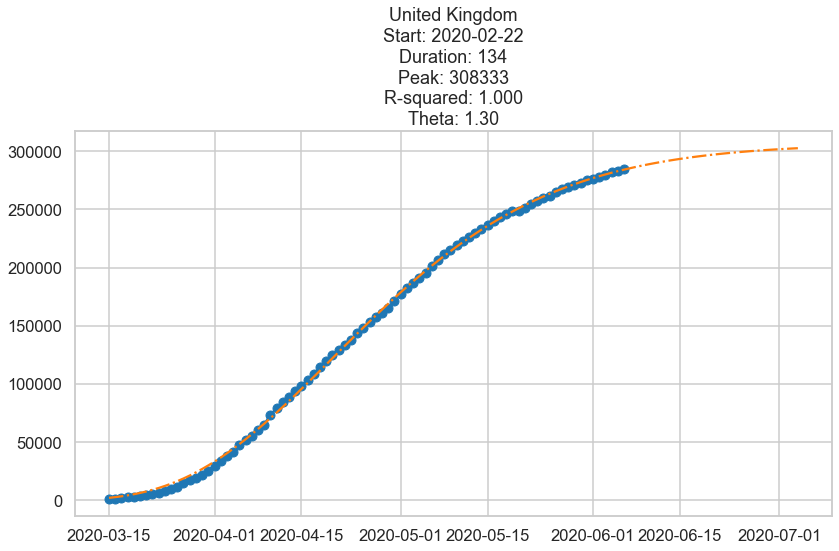

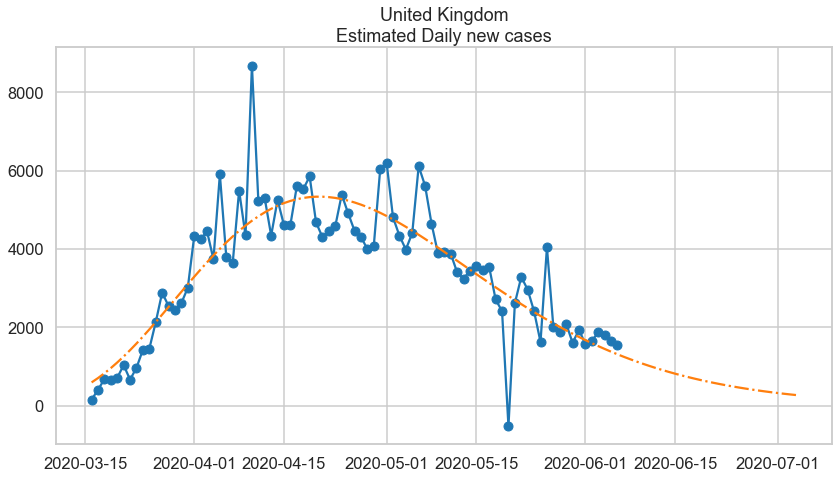

In [4]:
uk.display(offset=84)

## Are there day patterns?
Now we have a really close fitting function, we can check the residuals to see if there are patterns. Visually, there appears to be patterns in the high and low points on common days each week. Is this obvious in the residuals and their auto-correlation values?

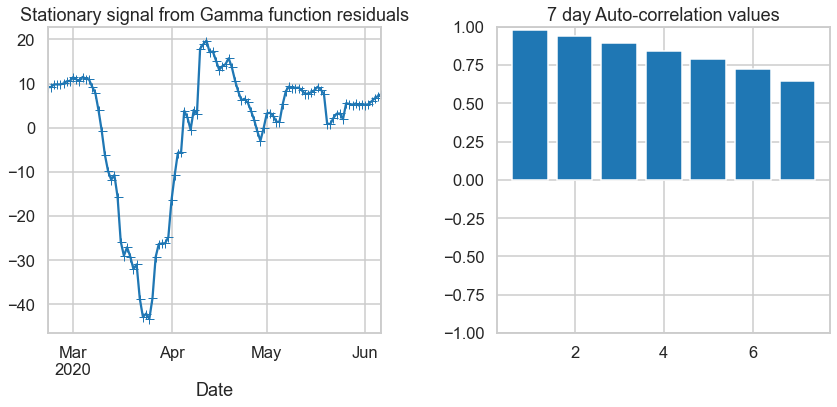

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(12,6))

df = gb_df[['Actual', 'Prediction']].dropna()
stationary = df['Actual'] - df['Prediction']
# Remove the heterscedacity to make the signal stationary
stationary /= df['Actual']**0.5
# balance above and below zero line
stationary -= stationary.mean()

stationary.plot(marker='+', ax=ax[0])
ax[0].set_title('Stationary signal from Gamma function residuals')

ac_lst = []
lags = list(range(1, 8))
for lag in lags:
    ac = stationary.autocorr(lag=lag)
    ac_lst.append(ac)

ax[1].bar(height=ac_lst, x=lags)
ax[1].set_ylim(bottom=-1, top=1)
ax[1].set_title('7 day Auto-correlation values')
plt.tight_layout()
plt.show()

Alas - I can't get the differences stationary. There are up and down patterns, but they are obscured by the fit being better in the middle of the curve, not the start when the values are small. Let's try a rolling average instead and measure the residuals from that.

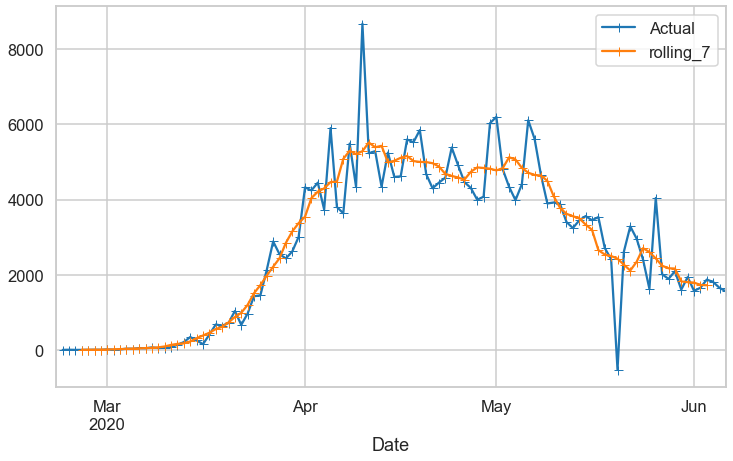

In [6]:
df['rolling_7'] = df['Actual'].rolling(7).mean().shift(-3).dropna()
df[['Actual', 'rolling_7']].diff().plot(figsize=(12,7), marker='+')
plt.show()

In [7]:
# Get the residual and make the signal stationary.
stationary = df['Actual'] - df['rolling_7']
# Remove heteroscedacity
stationary /= df['Actual']**0.5
# balance above and below zero line
stationary -= stationary.mean()

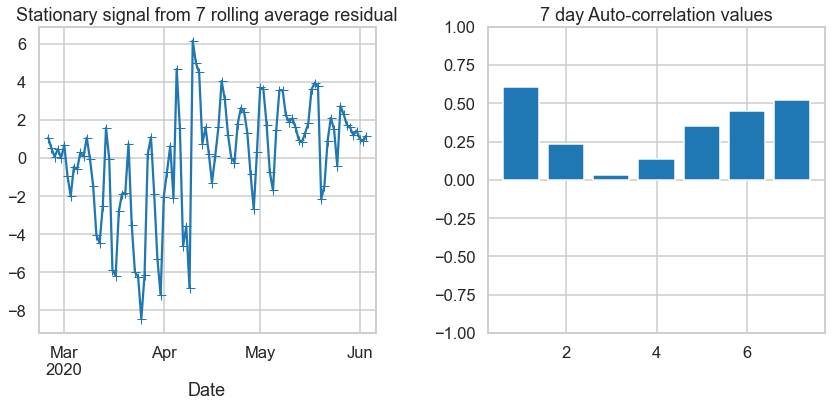

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
stationary.plot(marker='+', ax=ax[0])
ax[0].set_title('Stationary signal from 7 rolling average residual')

ac_lst = []
lags = list(range(1, 8))
for lag in lags:
    ac = stationary.autocorr(lag=lag)
    ac_lst.append(ac)

ax[1].bar(height=ac_lst, x=lags)
ax[1].set_ylim(bottom=-1, top=1)
ax[1].set_title('7 day Auto-correlation values')
plt.tight_layout()
plt.show()

That makes the patterns much clearer. We can clearly see cycles and this week (16th April) the auto-correlation is growing at day 7. i.e. there is support for a weekly cycle. If you count the days in each cycle, they can be shorter than 7 days and longer than 7 days. So the value is not close to 1 - but it is now at a level that shows support for weekly cycles. I suspect that support will increase, because we are less likely to have measurement delays on the down side of the curve (e.g. running out of tests, not having enough people to verify etc).

Even though the duration varies a little - could it be the peaks and lows occur in separate days of the week?

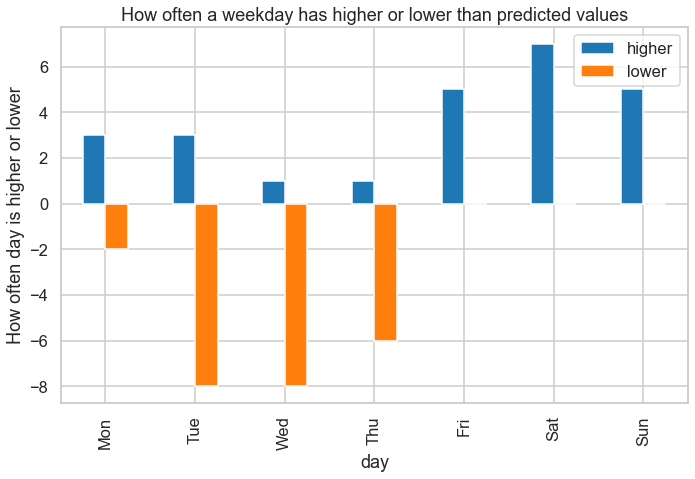

In [9]:
day_dict = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

stat_df = pd.DataFrame(stationary)
change = stat_df.rolling(7).agg(['max', 'min']).diff().replace({0: np.nan}).dropna(how='all')
change.columns = ['higher', 'lower']
change['day'] = change.index.dayofweek
comp_df = pd.DataFrame({'day': list(day_dict.values())}, index=list(range(7)))
max_df = change.dropna(subset=['higher'])[['higher', 'day']].groupby('day').count()
min_df = change.dropna(subset=['lower'])[['lower', 'day']].groupby('day').count()*-1
pd.concat([comp_df, max_df, min_df], axis=1).fillna(0).set_index('day').plot(kind='bar',
                                                                             figsize=(10,7))
plt.title('How often a weekday has higher or lower than predicted values')
plt.ylabel('How often day is higher or lower')
plt.tight_layout()
plt.show()

So yes, when you take residuals against a 7 day rolling average, early weekday case reports tend to be lows, and weekend case reports tend to be high. Also consider the reporting day is for cases on the prior day.

## Commentary
### 21st May
Model tweak - increased duration guess to get better fit: This parameter is deliberately restricted in the grid search to force the model to only fit the week around a specific duration guess.

### 7th May
Tweak the model parameters to match the new data. I can see the government slides split the pillars, but I would want to check each pillar isn't leaking into one another before considering just a hospital only model.

### 2nd May
The figures are higher because of increased testing. The official figures keeps the sources separate by dividing them into pillars. The first pillar was hospital admissions tested by the central lay. There are now another 2 pillars for key working testing, and the serology experiment sampling the population at large for surveillance. This will not change the most likely duration - but it will increase the total cases. The John Hopkins data does not split this out. If I get time, I might subclass the UK and find another source which does split these pillars. Then I can model on a like for like basis.

### 1st May
Update model - guess duration 115, guess peak 220,000. With a MLE theta of 0.9, this is getting closer to the spread of Italy - I suspect that is still our end point.

### 28th April
Updated model - guess duration 110, guess peak 210,000.

### 14th April
Tweaked seed duration higher, but start day lower. Get a slightly better fit and a slightly lower theta than Italy.

### 12th April
I've tuned the gamma model to use mu/theta parameters, and fit better grid search thresholds. The gamma is now the best fit for this and other countries. It is now the default.

### 11th April
I've written a new fit function based on the Gamma distribution. I like the fit - although it doesn't show as good an rsquared, I'm sure it will as we descend the slope. The skewed shape is much closer to the shape seen in Italy with a steeper ascent, and a slower, less sleep descent.

### 10th April
UK was not including key worker tests - these were all added today to catch up. That adds about 300-500 a day going forward. That curve appears to lag the population - which makes sense. They catch it in hospital, and there is a lag in testing for those people - perhaps up to 2 weeks until testing catches up and becomes pro-active. i.e. the test capacity will exceed the requirement to measure people with symptoms, and can start testing people with no symptoms in order of risk such as ICU, transport teams etc.

### 8th April
I'm erring more towards longer duration. I've updated accordingly.

### 7th April
I'm pretty sure the peak will be before this Sunday - but its hard to know if our duration is longer like Italy, or shorter like Germany.

### 3rd April
I suspect the testing is now catching up. I've returned the duration guess to 7*12 days, my initial duration for Italy. I know this is the most optimistic case, but I've seen other countries in Europe; Spain, France and possibly Germany, all show durations less than the current Italian spread. As always this only remains true if people behave in a way the suppresses the spread. It should be clear by the end of next week if we've passed peak new daily cases.

### 31st March
The total tests could be close to, or exceeding the current capacity to propose each day. We had 7k total tests performed today, with 33% shown as positive. A week ago we performed 3k tests (well under the initially capacity) and this showed 12% positive test rate. I would expect that ratio to stay fairly constant unless:
- Hospitals are being more specific with symptoms and testing a smaller set, and this is the real case.
- Hospitals are still testing everybody, but the processing can't keep up at the moment, and the real cases are higher, and will show as bigger peaks in later days.

I tend towards the later explanation, so I'm going to keep the model stats close to Italy for now.


## Previous Model Values
This tracks the best model parameters as the virus spread.

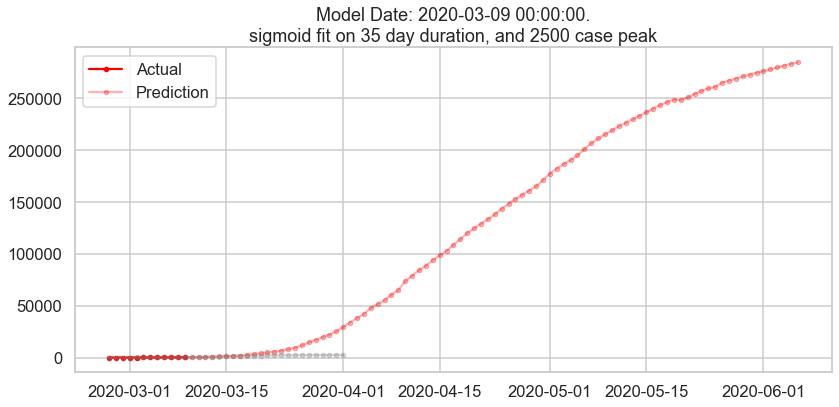

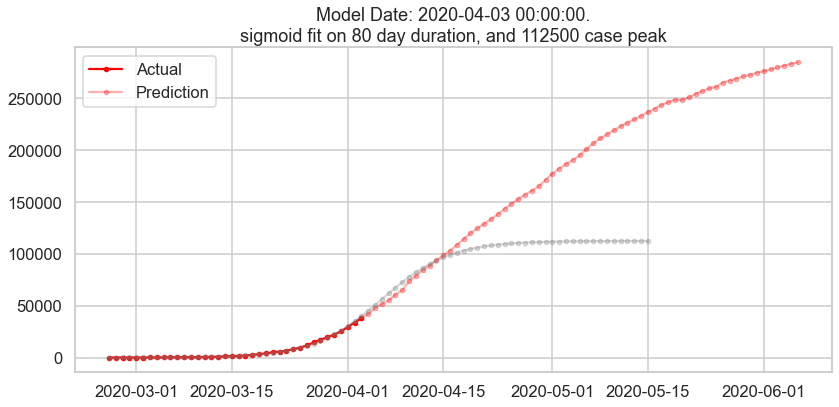

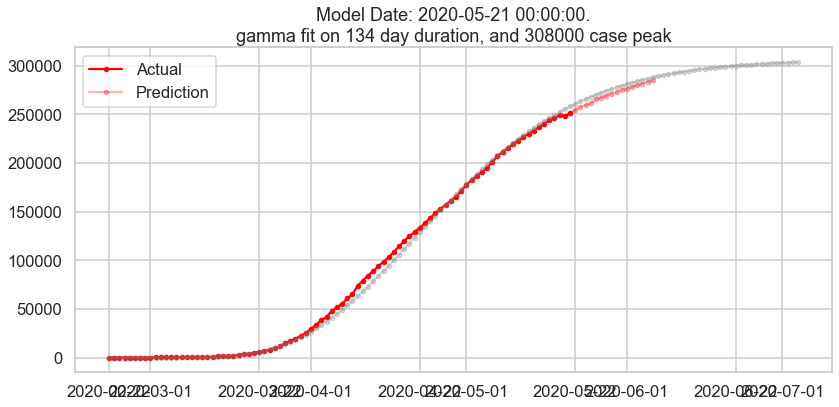

In [10]:
import src.covid as covid
import matplotlib.pyplot as plt
import pandas as pd


# Track best model parameter values over time
best_fit_df = pd.read_csv('../data/raw/gb_best_fit_params.csv', parse_dates=['date'], index_col='date')

# Plot fit for the first, middle and latest paramters
for date in best_fit_df.iloc[[0,int(len(best_fit_df)/2),-1]].index:
    case_lst = []
    duration = best_fit_df.loc[date, 'duration']
    peak = best_fit_df.loc[date, 'peak']
    spread = best_fit_df.loc[date, 'spread']
    start = best_fit_df.loc[date, 'start']
    theta = best_fit_df.loc[date, 'theta']
    curve = best_fit_df.loc[date, 'curve']
    for i in range(0, duration):
        if curve == 'sigmoid':
            case_lst.append(covid.sig_pred_case(i, duration=duration, peak=peak, spread=spread))
        elif curve == 'gamma':
            case_lst.append(covid.gamma_pred_case(i, theta=theta, duration=duration, peak=peak))
    pred_df = pd.DataFrame({'Prediction': case_lst}, index=pd.date_range(start, periods=duration))

    fig, ax = plt.subplots(1,1,figsize=(12,6))
    plt.plot(gb_df.loc[start:date, 'Actual'], marker='.', color='red')
    plt.plot(gb_df.loc[date:, 'Actual'], marker='.', color='red', alpha=0.3)
    plt.plot(pred_df['Prediction'], marker='.', color='grey', alpha=0.3)
    plt.legend(['Actual', 'Prediction'])
    plt.title(f'Model Date: {date}.\n{curve} fit on {duration} day duration, and {peak} case peak')
    plt.tight_layout()
    plt.show()

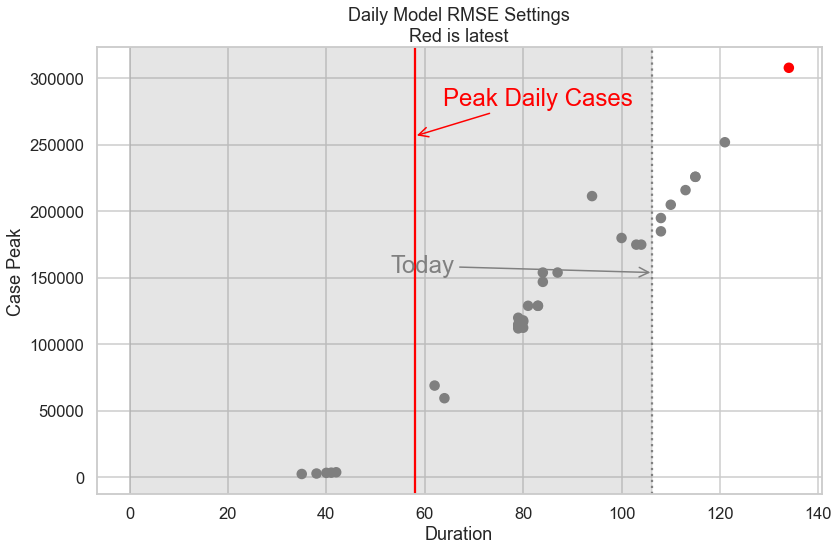

In [11]:
# Scatter plot the parameters
dur_so_far = pd.Timestamp.now() - gb_df.index.min()
dur_so_far /= pd.Timedelta('1D')

color_lst = ['gray'] * int(len(best_fit_df) - 1)
color_lst.append('red')

fig, ax = plt.subplots(1,1,figsize=(12, 8))
ax.scatter(y=best_fit_df['peak'],
           x=best_fit_df['duration'],
           c=color_lst)
text_color = 'grey'
plt.axvspan(xmin=0, xmax=dur_so_far, color='tab:grey', alpha=0.2)
plt.axvline(dur_so_far, color=text_color, linestyle=':')
plt.annotate(s='Today',
             xy=(dur_so_far, best_fit_df['peak'].max()/2),
             arrowprops={'arrowstyle': '->',
                         'color': text_color},
             xytext=(dur_so_far/2, best_fit_df['peak'].max()/2),
             color=text_color,
             fontsize=24)
# With gamma function, peak is sooner than mid-point
pred_mid_point = gb_df['Prediction'].diff().idxmax() - gb_df['Prediction'].index.min()
pred_mid_point /= pd.Timedelta('1D')
plt.axvline(x=pred_mid_point, color='red')
plt.annotate(s='Peak Daily Cases',
             xy=(pred_mid_point, best_fit_df['peak'].max()/1.2),
             arrowprops={'arrowstyle': '->',
                         'color': 'red'},
             xytext=(pred_mid_point*1.1, best_fit_df['peak'].max()/1.1),
             color='red',
             fontsize=24)
plt.title('Daily Model RMSE Settings\nRed is latest')
plt.ylabel('Case Peak')
plt.xlabel('Duration')
plt.tight_layout()
plt.show()